# Capstone Project, Model #2: Random Forest Classifier

In this section, a RandomForestClassifier model will be created.  

After the model is created, it will learn from the data developed in the Data Collection and EDA phases, after which the model will develop its own rules of when enter and exit trades.  

Lastly, its performance is gaged against the performance of the trading strategy developed in the EDA section.

## Import Libraries

In [183]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score

import warnings
warnings.filterwarnings("ignore")

## Import Data

In [184]:
gld_data = pd.read_csv('./data/gld_data.csv', index_col=0)

In [185]:
gld_data.head()

,Open,High,Low,Close,RSI,pSAR,TEMA,ADX
Date,,,,,,,,
2011-02-10,132.110001,133.309998,132.000000,132.850006,46.092442,128.876541,131.462458,33.107729
2011-02-11,133.009995,133.440002,132.089996,132.320007,44.099798,129.153949,131.675929,31.074322
2011-02-14,132.949997,133.380005,132.699997,132.949997,47.031123,129.414712,131.874588,29.186158
2011-02-15,133.860001,134.169998,133.630005,133.970001,51.468512,129.659829,132.094962,27.407409
2011-02-16,134.229996,134.860001,133.449997,134.100006,52.020217,130.020643,132.338897,26.263413


- Restore the datatime index that was lost when the dataset was exported to CSV file.

In [186]:
gld_data.index = pd.to_datetime(gld_data.index)

In [187]:
gld_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2734 entries, 2011-02-10 to 2021-12-20
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2734 non-null   float64
 1   High    2734 non-null   float64
 2   Low     2734 non-null   float64
 3   Close   2734 non-null   float64
 4   RSI     2734 non-null   float64
 5   pSAR    2734 non-null   float64
 6   TEMA    2734 non-null   float64
 7   ADX     2734 non-null   float64
dtypes: float64(8)
memory usage: 192.2 KB


## Define Predictor `X` and Target `y`  Variables

In the EDA section, a trading strategy was created using technical indicators (`RSI`, `pSAR`, `TEMA`, `ADX`) and daily returns (`Daily_Return`).  

In this section, the technical indicators and daily returns will be used as predictors and the target variable will be the signal _(i.e., The `signal` column in the previously created trading strategy)_ that was generated in the trading strategy.

For daily returns, the daily `Future_Return` will be calucated by using the `shift` method.  For example, for January 28, 2020, the return that was calculated for January 29 is used to generate the `Target` value for that day.

For the `Target`, `0` will denote negative returns, and `1` will denote positive returns.  Remember, in the previous strategy, `0` denotes an EXIT from a BUY position, and `1` denotes to open a BUY position.

- Create `Future_Return` column

In [188]:
gld_data['Future_Return'] = gld_data['Close'].pct_change(1).shift(-1)

- Create `Target` column

In [189]:
gld_data['Target'] = np.where(gld_data['Future_Return'] > 0, 1, 0)

In [190]:
gld_data

,Open,High,Low,Close,RSI,pSAR,TEMA,ADX,Future_Return,Target
Date,,,,,,,,,,
2011-02-10,132.110001,133.309998,132.000000,132.850006,46.092442,128.876541,131.462458,33.107729,-0.003989,0
2011-02-11,133.009995,133.440002,132.089996,132.320007,44.099798,129.153949,131.675929,31.074322,0.004761,1
2011-02-14,132.949997,133.380005,132.699997,132.949997,47.031123,129.414712,131.874588,29.186158,0.007672,1
2011-02-15,133.860001,134.169998,133.630005,133.970001,51.468512,129.659829,132.094962,27.407409,0.000970,1
2011-02-16,134.229996,134.860001,133.449997,134.100006,52.020217,130.020643,132.338897,26.263413,0.007010,1
...,...,...,...,...,...,...,...,...,...,...
2021-12-14,165.339996,166.139999,165.160004,165.440002,40.924239,167.686717,166.638833,11.175713,0.004292,1
2021-12-15,165.270004,166.399994,163.800003,166.149994,44.258064,167.381046,166.549802,11.945480,0.012098,1
2021-12-16,167.009995,168.179993,166.940002,168.160004,52.440786,163.800003,166.544353,11.471833,-0.002141,0


- Drop `NaNs` and create `X` and `y` variables

In [191]:
gld_data = gld_data.dropna()

In [192]:
gld_data.isnull().sum()

Open             0
High             0
Low              0
Close            0
RSI              0
pSAR             0
TEMA             0
ADX              0
Future_Return    0
Target           0
dtype: int64

In [193]:
X = gld_data[['RSI', 'pSAR', 'TEMA', 'ADX' ]]

In [194]:
X

,RSI,pSAR,TEMA,ADX
Date,,,,
2011-02-10,46.092442,128.876541,131.462458,33.107729
2011-02-11,44.099798,129.153949,131.675929,31.074322
2011-02-14,47.031123,129.414712,131.874588,29.186158
2011-02-15,51.468512,129.659829,132.094962,27.407409
2011-02-16,52.020217,130.020643,132.338897,26.263413
...,...,...,...,...
2021-12-13,46.612048,168.026352,166.730779,11.104600
2021-12-14,40.924239,167.686717,166.638833,11.175713
2021-12-15,44.258064,167.381046,166.549802,11.945480


In [195]:
y = gld_data['Target']

In [196]:
y

Date
2011-02-10    0
2011-02-11    1
2011-02-14    1
2011-02-15    1
2011-02-16    1
             ..
2021-12-13    0
2021-12-14    1
2021-12-15    1
2021-12-16    0
2021-12-17    0
Name: Target, Length: 2733, dtype: int32

## Split dataset into training and test sets

- Determine split

In [197]:
split_pct = 0.75
split = int(split_pct * len(X))

- Get training set

In [198]:
X_train = X[:split]
y_train = y[:split]

- Get test set

In [199]:
X_test = X[split:]
y_test = y[split:]

- Check split

In [200]:
print('Training shape: ', X_train.shape, y_train.shape)
print('Test shape: ', X_test.shape, y_test.shape)

Training shape:  (2049, 4) (2049,)
Test shape:  (684, 4) (684,)


## Null Model

In [201]:
gld_data['Target'].value_counts(normalize=True)

1    0.520673
0    0.479327
Name: Target, dtype: float64

In this dataset 47.9% of the signals are not BUY signals. This means that if we assign a signal as never BUY, we would have a baseline accuracy of 47.9%.

## Model: RandomForestClassifier

- Instantiate and fit a RandomForestClassifer object

In [202]:
rf = RandomForestClassifier(max_depth=4)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=4)

- Make predictions

In [203]:
y_pred = rf.predict(X_test)

- Evaluate model

In [204]:
print('Random Forest Classifier metrics\n')
print('           training           testing')
print('Accuracy: ', rf.score(X_train,y_train),rf.score(X_test,y_test))
print('f1:       ',f1_score(y_train,rf.predict(X_train)),f1_score(y_test,y_pred))

Random Forest Classifier metrics

           training           testing
Accuracy:  0.6388482186432406 0.5219298245614035
f1:        0.6898575020955574 0.5374823196605375


Accuracy and f1 scores aren't stellar.  However, anything above 0.5 is considered to be good.  The difference in training and testing scores there is more overfitting and more bias in this model versus the DecisionTree model. 

- Plot confusion matrix

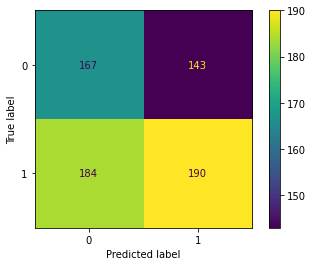

In [205]:
plot_confusion_matrix(rf,X_test,y_test);

For this model, there are slightly more Type II errors (184) than Type I errors (143). 

Here, the Type II errors represent erroneously accepting the null hypothesis, when in fact it should have been rejected.  In other words, the model should have acted on the signal and bought GLD.  This is the less severe error in this situation.

The Type I errors represent the rejection of the null hypothesis _(i.e., the signal is not a BUY signal)_, and the execution of a BUY order.   

This is the most severe error in this situation.  

### Strategy Returns

In the EDA section, the strategy returns were determined by muliplying the `signal` (`0` or `1`) by the `Daily_Return`.

In this section, we will use the `Close` prices, `Daily_Returns`, and the `y_pred` values _(in place of `signal`)_ to calculate strategy returns.

- Make copy of `gld_data` dataframe

In [207]:
strategy_data = gld_data.copy()

In [208]:
strategy_data.head()

,Open,High,Low,Close,RSI,pSAR,TEMA,ADX,Future_Return,Target
Date,,,,,,,,,,
2011-02-10,132.110001,133.309998,132.000000,132.850006,46.092442,128.876541,131.462458,33.107729,-0.003989,0
2011-02-11,133.009995,133.440002,132.089996,132.320007,44.099798,129.153949,131.675929,31.074322,0.004761,1
2011-02-14,132.949997,133.380005,132.699997,132.949997,47.031123,129.414712,131.874588,29.186158,0.007672,1
2011-02-15,133.860001,134.169998,133.630005,133.970001,51.468512,129.659829,132.094962,27.407409,0.000970,1
2011-02-16,134.229996,134.860001,133.449997,134.100006,52.020217,130.020643,132.338897,26.263413,0.007010,1


- Calculate `Daily_Return`

> The `Daily_Return` is the percentage change in the closing price from the previous day to the present day.

In [209]:
strategy_data['Daily_Return'] = strategy_data['Close'].pct_change()

In [210]:
strategy_data.head()

,Open,High,Low,Close,RSI,pSAR,TEMA,ADX,Future_Return,Target,Daily_Return
Date,,,,,,,,,,,
2011-02-10,132.110001,133.309998,132.000000,132.850006,46.092442,128.876541,131.462458,33.107729,-0.003989,0,NaN
2011-02-11,133.009995,133.440002,132.089996,132.320007,44.099798,129.153949,131.675929,31.074322,0.004761,1,-0.003989
2011-02-14,132.949997,133.380005,132.699997,132.949997,47.031123,129.414712,131.874588,29.186158,0.007672,1,0.004761
2011-02-15,133.860001,134.169998,133.630005,133.970001,51.468512,129.659829,132.094962,27.407409,0.000970,1,0.007672
2011-02-16,134.229996,134.860001,133.449997,134.100006,52.020217,130.020643,132.338897,26.263413,0.007010,1,0.000970


- Drop all columns except `Close` and `Daily_Return`

In [211]:
strategy_data = strategy_data[['Close', 'Daily_Return']]

In [212]:
strategy_data

,Close,Daily_Return
Date,,
2011-02-10,132.850006,NaN
2011-02-11,132.320007,-0.003989
2011-02-14,132.949997,0.004761
2011-02-15,133.970001,0.007672
2011-02-16,134.100006,0.000970
...,...,...
2021-12-13,167.000000,0.002521
2021-12-14,165.440002,-0.009341
2021-12-15,166.149994,0.004292


- Get the `strategy_data` that corresponds to the `y_pred` values

In [214]:
strategy_test = strategy_data[split:]

- Check the shape of `strategy_test` and `y_pred`

In [215]:
strategy_test.shape, y_pred.shape

((684, 2), (684,))

- Add `y_pred` as a column to `stragegy_test`

In [216]:
strategy_test['Predicted_Signal'] = y_pred.tolist()

In [217]:
strategy_test

,Close,Daily_Return,Predicted_Signal
Date,,,
2019-04-04,122.110001,0.002545,0
2019-04-05,121.980003,-0.001065,0
2019-04-08,122.510002,0.004345,0
2019-04-09,123.150002,0.005224,0
2019-04-10,123.529999,0.003086,0
...,...,...,...
2021-12-13,167.000000,0.002521,0
2021-12-14,165.440002,-0.009341,0
2021-12-15,166.149994,0.004292,0


- Calculate Strategy Returns

> To calculate strategy returns, the `Daily_Return` is multiplied by the previous day's `Predicted_Signal`. Here, it is assumed that the corresponding execution happens at the close of the day.

In [218]:
strategy_test['Strategy_Returns'] = (strategy_test['Daily_Return'] * strategy_test['Predicted_Signal'].shift(1))

In [219]:
strategy_test.head()

,Close,Daily_Return,Predicted_Signal,Strategy_Returns
Date,,,,
2019-04-04,122.110001,0.002545,0,NaN
2019-04-05,121.980003,-0.001065,0,-0.0
2019-04-08,122.510002,0.004345,0,0.0
2019-04-09,123.150002,0.005224,0,0.0
2019-04-10,123.529999,0.003086,0,0.0


- Drop `NaNs`

In [220]:
strategy_test = strategy_test.dropna()

- Calculate cumulative strategy returns

In [221]:
cumulative_strategy_returns = (strategy_test['Strategy_Returns']+1).cumprod()

- Calculate absolute returns

In [222]:
total_returns = (cumulative_strategy_returns.iloc[-1]-1)*100

print('The total returns of strategy is %.2f' % total_returns + '%')

The total returns of strategy is 39.62%


## Findings

1. The Random Forest Classifier model was able a generate return of 39.62%, on the test data, which is greater than the return of 6.31% generated by the mechanical system.


2. Although the accuracy and f1 scores were lower than desired, they are still better slightly better than average.  Further, this model had higher bias and variance than the both the Decision Tree Classifier and Logistics Regression models.


3. The model had the least amount of variance between the its training and test metrics (accuracy and f1) of the three models _(the other two are Logistic Regression and Decision Tree)._


4. The model metrics, and subseqent strategy performance, improved with an increase in data. Initially, the model achieved less performing metrics on two years of data from December 2019 to December 2021. After expanding the dataset to 10 years (December 2011 to December 2021), the model's metrics improved.